# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Test if GPU is available
# Note that CUDA below 12.1 can have bugs
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
12.1


In [3]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate correlated background but no synapse

In [5]:
######### Settings (need to run even if the data is already generated) #########
external_input_params = {
    "external_input_type": "two_peaks_with_all_varying",
    "std1": 10,
    "corr1": 0.5,
    "std2": 25,
    "corr2": 0.5,
    "use_two_modes": False,
    "gp_time_constant": 300,
    "gp_amplitude": 0.05,
}

conn = 0.0
nneuron_coupling = 10
nneuron = 100
nneuron_part = nneuron//2
npadding = 50

shared_background_list = [0.0, 0.2, 0.4]
nrep = 5

In [58]:
########## Generate synthetic data (no need to run) ###########

for shared_background in shared_background_list:
    for rep in range(nrep):
        spikes, trial_info, I_ext, I_syn = GLM.EIF_simulator(
            ntrial=2000,
            nneuron=nneuron,
            conn=conn,
            nneuron_coupling=nneuron_coupling,
            params=external_input_params,
            shared_background=shared_background,
            no_stimulus=False,
            return_trial_info=True,
            return_I_ext=True,
            return_I_syn=True,
        )
        file_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'
        np.savez_compressed(file_name,
                            spikes=spikes,
                            trial_info=trial_info,
                            I_ext=I_ext,
                            I_syn=I_syn)



100%|██████████| 2000/2000 [02:56<00:00, 11.34it/s]


# Our method and our method abalated

In [105]:
def fit_model(data_to_use, FIT_THE_BASELINE_MODEL):

    ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

    params = {
        # B-spline basis
        'num_B_spline_basis': 20,
        # Transformer VAE's settings
        'downsample_factor': 10,
        'transformer_num_layers': 2,
        'transformer_d_model': 128,
        'transformer_dim_feedforward': 512,
        'transformer_vae_output_dim': 16,
        'transformer_dropout': 0.0,
        'transformer_nhead': 1,
        'stimulus_nfactor': 1,
        'stimulus_decoder_inter_dim_factor': 2,
        'beta': 1.0,
        'use_area_specific_decoder': True,
        'use_area_specific_encoder': True,
        'use_cls': False,
        # Coupling's settings
        'coupling_basis_peaks_max': 5,
        'coupling_basis_num': 3,
        'coupling_nsubspace': 1,
        'use_self_coupling': True,
        # Coupling strength latent's settings
        'K_sigma2': 1.0,
        'K_tau': 100,
        'coupling_strength_nlatent': 1,
        # Self-history's settings
        'self_history_basis_peaks_max': 1.5,
        'self_history_basis_num': 3,
        'self_history_basis_nonlinear': 1,
        # Penalty settings
        'penalty_smoothing_spline': 1e2,
        'penalty_coupling_subgroup': 1e-5,
        'penalty_diff_loading': None,
        'penalty_loading_similarity': None,
        # Training settings
        'batch_size': 64,
        'sample_latent': False,
        'lr': 1e-3,
        'epoch_warm_up': 0,
        'epoch_patience': 3,
        'epoch_max': 200,
        'tol': 1e-5,
        'weight_decay': 0,
        'lr_transformer': 1e-4,
        'lr_sti': 1e-2,
        'lr_cp': 1e-2,
        'lr_self_history': 1e-2,
    }

    trainer = Trainer(data_to_use, ckp_path, params)

    if FIT_THE_BASELINE_MODEL:
        # Baseline model: no trial-varying stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=True,
            fix_latents=True,
            verbose=False,
        )

    else:
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=False,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=False,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=False,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=False,
            record_results=True,
        )


    ### Which dataset to use?
    loader = trainer.dataloader.test_loader

    ###
    trainer.model.normalize_coupling_coefficients()
    trainer.model.eval()
    trainer.model.sample_latent = False
    test_loss = 0.0
    test_loss_baseline = 0.0
    total_trial = 0
    test_loss_record = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader)):
            trainer.process_batch(batch)
            firing_rate = trainer.model(
                batch,
                include_stimulus=True,
                include_coupling=True,
                fix_stimulus=False,
                fix_latents=True,
            )
            loss = trainer.model.loss_function(
                firing_rate, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_record.append(loss.item())
            test_loss += loss.item() * batch["spike_trains"].size(2)
            total_trial += batch["spike_trains"].size(2)
            if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
                firing_rate_baseline = (
                    torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                        * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
                )
            
            loss_baseline = trainer.model.loss_function(
                firing_rate_baseline, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

    test_loss /= total_trial
    test_loss_baseline /= total_trial
    print(f"Test loss: {test_loss}")
    print(f"Test loss baseline: {test_loss_baseline}")

    all_firing_rates = []
    all_firing_rates_coupling = []
    for ibatch in range(len(trainer.dataloader.test_batches)):
        firing_rate_test, _, _, _, _ = trainer.predict(
            dataset='test',
            batch_indices=[ibatch],
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
            return_torch=True,
            return_trial_indices=True,
            return_spike_trains=True,
        )
    
        neuron_indices = np.arange(nneuron_part,nneuron_part+nneuron_part)
        all_firing_rates.append(firing_rate_test[:, neuron_indices, :].cpu().numpy())
        all_firing_rates_coupling.append(
            trainer.model.coupling_outputs[0][1][:, :nneuron_part, :].cpu().numpy().transpose(2,1,0)
        )
    all_firing_rates = np.concatenate(all_firing_rates, axis=2)
    all_firing_rates_coupling = np.concatenate(all_firing_rates_coupling, axis=2)
    all_firing_rates_wo_coupling = all_firing_rates - all_firing_rates_coupling

    all_firing_rates = np.exp(all_firing_rates)
    all_firing_rates_wo_coupling = np.exp(all_firing_rates_wo_coupling)
    total_variance = all_firing_rates.var(axis=(0,2))
    variance_wo_coupling = all_firing_rates_wo_coupling.var(axis=(0,2))
    return ((total_variance - variance_wo_coupling) / total_variance).mean()


In [110]:
var_by_coupling_percentage_matrix = np.zeros((len(shared_background_list), nrep))
var_by_coupling_percentage_matrix_base_model = np.zeros((len(shared_background_list), nrep))
for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):
        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes']
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']

        synthetic_dataloader = Simple_dataloader_from_spikes(
            [spikes[:,:nneuron_part,:], spikes[:,nneuron_part:,:]],
            npadding=50,
            train_ratio=0.7,
            val_ratio=0.1,
            batch_size=64,
            verbose=True
        )

        result = fit_model(synthetic_dataloader, False)
        result_base_model = fit_model(synthetic_dataloader, True)

        var_by_coupling_percentage_matrix[i_shared_background, rep] = (
            result
        )
        var_by_coupling_percentage_matrix_base_model[i_shared_background, rep] = (
            result_base_model
        )
    
# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix.npy', 
        var_by_coupling_percentage_matrix)
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_base_model.npy',
        var_by_coupling_percentage_matrix_base_model)


Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 177.27it/s]


Test loss: 0.22510227843413033
Test loss baseline: 0.2308225328116643
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 180.20it/s]


Test loss: 0.2355175592060993
Test loss baseline: 0.2309132344333311
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 183.76it/s]


Test loss: 0.22522032866602823
Test loss baseline: 0.23102089290755645
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 166.25it/s]


Test loss: 0.2360672039952956
Test loss baseline: 0.23111409298202343
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 133.29it/s]


Test loss: 0.2253467995404008
Test loss baseline: 0.23101095535660027
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 123.97it/s]


Test loss: 0.23615350431188978
Test loss baseline: 0.23110619239379046
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 183.99it/s]


Test loss: 0.22625870047662025
Test loss baseline: 0.23210645011832887
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 158.37it/s]


Test loss: 0.23707895556887487
Test loss baseline: 0.2322018552302125
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 185.26it/s]


Test loss: 0.22510227843413033
Test loss baseline: 0.2308225328116643
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 134.96it/s]


Test loss: 0.2355175592060993
Test loss baseline: 0.2309132344333311
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 158.63it/s]


Test loss: 0.22329871230143264
Test loss baseline: 0.22896141839443596
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 156.03it/s]


Test loss: 0.23379139182276262
Test loss baseline: 0.22905601531341485
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 173.98it/s]


Test loss: 0.2246776531982303
Test loss baseline: 0.23032762719657357
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 181.49it/s]


Test loss: 0.2353802252737364
Test loss baseline: 0.23042230776271916
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 185.66it/s]


Test loss: 0.22555358945728834
Test loss baseline: 0.23121027815668957
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 154.42it/s]


Test loss: 0.2362653613833715
Test loss baseline: 0.23130063868668907
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 171.41it/s]


Test loss: 0.22477328688129225
Test loss baseline: 0.23036248342800617
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 152.12it/s]


Test loss: 0.23541116517529523
Test loss baseline: 0.23045642287505239
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 183.58it/s]


Test loss: 0.22397426640303653
Test loss baseline: 0.22954741811514495
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 167.18it/s]


Test loss: 0.2342973492686588
Test loss baseline: 0.22964138494911338
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 174.95it/s]


Test loss: 0.22726936608627252
Test loss baseline: 0.2326514531772333
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 184.13it/s]


Test loss: 0.2379212871454006
Test loss baseline: 0.23274312140489753
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 185.82it/s]


Test loss: 0.22168089598045682
Test loss baseline: 0.22733396120796776
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 165.79it/s]


Test loss: 0.23186839396073633
Test loss baseline: 0.2274265592903865
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 152.65it/s]


Test loss: 0.22053085048299775
Test loss baseline: 0.22681077266869104
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 187.08it/s]


Test loss: 0.23140460880765892
Test loss baseline: 0.2269025430120435
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 181.36it/s]


Test loss: 0.22999732185183022
Test loss baseline: 0.2354707420243884
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 180.81it/s]


Test loss: 0.2406363408464446
Test loss baseline: 0.23555988485825033
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 176.05it/s]


Test loss: 0.22221590604568062
Test loss baseline: 0.22800062284653919
Model initialized. Training on cuda


100%|██████████| 7/7 [00:00<00:00, 178.68it/s]

Test loss: 0.23273213289473715
Test loss baseline: 0.22809030869952462


# Reduced rank regression

In [86]:
####### Reduced Rank Regression ########
from GLM import reduced_rank_regression
num_trials_to_use = 2000
merge_time = 10
var_by_coupling_percentage_matrix_rrr = np.zeros((len(shared_background_list), nrep))
for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):

        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes'][:, :, :num_trials_to_use]
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']
        nt, nneuron, ntrial = spikes.shape

        spikes_merged = spikes.reshape(
            int(nt/merge_time), 
            merge_time, 
            nneuron, 
            ntrial
        ).sum(axis=1)
        X = spikes_merged[:, :50, :]
        Y = spikes_merged[:, 50:, :]
        var_by_coupling_percentage_matrix_rrr[i_shared_background, rep] = (
            reduced_rank_regression(X, Y, 1)
        )

# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_rrr.npy', 
        var_by_coupling_percentage_matrix_rrr)


# Single-neuron GLM

In [89]:
######### Single-neuron GLM ##########
# Randomly sample some neurons in area 2 and fit the model
num_trials_to_use = 200
from GLM import PP_GLM
var_by_coupling_percentage_matrix_single_neuron_GLM = np.zeros((len(shared_background_list), nrep))

for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):
        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes'][:, :, :num_trials_to_use]
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']
        nt, nneuron, ntrial = spikes.shape

        all_trials = np.array( [True]*ntrial )
        var_list = []
        for output_neuron in tqdm(range(nneuron_part, 2*nneuron_part)):
            model = PP_GLM(ntrial=ntrial, nt=nt, select_trials=all_trials)
            model.add_effect("inhomogeneous_baseline", num=20, apply_no_penalty=True)
            for input_neuron in range(nneuron):
                model.add_effect("coupling", raw_input=spikes[:,input_neuron,:], 
                                num=3, peaks_max=5, nonlinear=1)
            model.fit(target=spikes[:,output_neuron,:], method='mine', penalty=1e2, verbose=False)
            var_by_all_predictors = (np.exp(model.predictors@model.results.params)).var()
            params_not_coupling = np.concatenate([np.arange(20), np.arange(20+3*nneuron_part, 20+6*nneuron_part)])
            var_wo_coupling = (
                np.exp(model.predictors[:,params_not_coupling]@model.results.params[params_not_coupling])
            ).var()
            var_list.append((var_by_all_predictors - var_wo_coupling) / var_by_all_predictors)
        var_by_coupling_percentage_matrix_single_neuron_GLM[i_shared_background, rep] = (
            np.mean(var_list)
        )

# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM.npy', 
        var_by_coupling_percentage_matrix_single_neuron_GLM)


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


# Single-neuron GLM with trial-specific gain

In [114]:
######### Single-neuron GLM ##########
# Randomly sample some neurons in area 2 and fit the model
num_trials_to_use = 200

from GLM import PP_GLM
var_by_coupling_percentage_matrix_single_neuron_GLM_gain = np.zeros((len(shared_background_list), nrep))

for i_shared_background, shared_background in enumerate(shared_background_list):
    for rep in range(nrep):
        load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/'\
            +f'synthetic_data_EIF_conn={str(conn)}_corr={shared_background}_rep={rep}.npz'

        data = np.load(load_data_name, allow_pickle=True)
        spikes = data['spikes'][:, :, :num_trials_to_use]
        trial_info = data['trial_info']
        I_ext = data['I_ext']
        I_syn = data['I_syn']
        nt, nneuron, ntrial = spikes.shape

        all_trials = np.array( [True]*ntrial )
        var_list = []
        for output_neuron in tqdm(range(nneuron_part, 2*nneuron_part)):
            model = PP_GLM(ntrial=ntrial, nt=nt, select_trials=all_trials)
            model.add_effect("inhomogeneous_baseline", num=20, apply_no_penalty=True)
            model.add_effect("trial_coef", apply_no_penalty=True)
            for input_neuron in range(nneuron):
                model.add_effect("coupling", raw_input=spikes[:,input_neuron,:], 
                                num=3, peaks_max=5, nonlinear=1)
            model.fit(target=spikes[:,output_neuron,:], method='mine', penalty=1e2, 
                      no_penalty_term_penalty=3e-3, verbose=False)
            var_by_all_predictors = (np.exp(model.predictors@model.results.params)).var()
            params_not_coupling = np.concatenate([np.arange(220), np.arange(220+3*nneuron_part, 220+6*nneuron_part)])
            var_wo_coupling = (
                np.exp(model.predictors[:,params_not_coupling]@model.results.params[params_not_coupling])
            ).var()
            var_list.append((var_by_all_predictors - var_wo_coupling) / var_by_all_predictors)
        var_by_coupling_percentage_matrix_single_neuron_GLM_gain[i_shared_background, rep] = (
            np.mean(var_list)
        )

# Save the variance explained matrices
np.save('/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM_gain.npy', 
        var_by_coupling_percentage_matrix_single_neuron_GLM_gain)


100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


# Plot

In [12]:
### Load results
var_by_coupling_percentage_matrix = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix.npy'
)
var_by_coupling_percentage_matrix_base_model = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_base_model.npy'
)
var_by_coupling_percentage_matrix_rrr = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_rrr.npy'
)
var_by_coupling_percentage_matrix_single_neuron_GLM = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM.npy'
)
var_by_coupling_percentage_matrix_single_neuron_GLM_gain = np.load(
    '/home/qix/user_data/EIF_simulation_dataset/var_by_coupling_percentage_matrix_single_neuron_GLM_gain.npy'
)


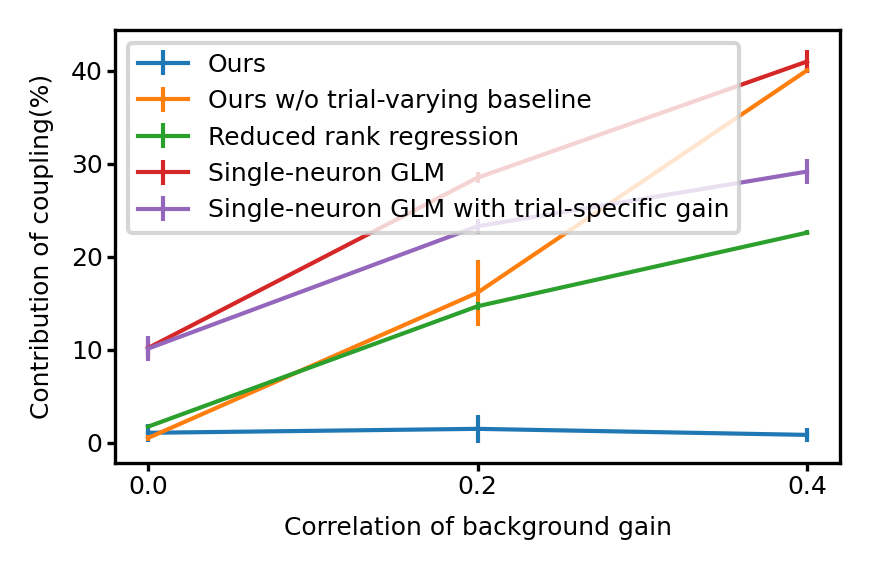

In [115]:
utils.use_pdf_plot()
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)

for results in [
    var_by_coupling_percentage_matrix,
    var_by_coupling_percentage_matrix_base_model,
    var_by_coupling_percentage_matrix_rrr,
    var_by_coupling_percentage_matrix_single_neuron_GLM[:,:],
    var_by_coupling_percentage_matrix_single_neuron_GLM_gain[:,:]
]:
    plt.errorbar(shared_background_list, results.mean(axis=1), results.std(axis=1)/np.sqrt(results.shape[1]))

# for results in [
#     var_by_coupling_percentage_matrix.mean(axis=1),
#     var_by_coupling_percentage_matrix_base_model[:,4],
#     var_by_coupling_percentage_matrix_rrr.mean(axis=1),
#     var_by_coupling_percentage_matrix_single_neuron_GLM[:,0],
#     var_by_coupling_percentage_matrix_single_neuron_GLM_gain[:,0]
# ]:
#     plt.plot(shared_background_list, results)

plt.legend([
    "Ours",
    "Ours w/o trial-varying baseline",
    "Reduced rank regression",
    "Single-neuron GLM",
    "Single-neuron GLM with trial-specific gain",
])

plt.xticks([0.0, 0.2, 0.4])
plt.gca().yaxis.set_major_formatter(lambda x, pos: f'{x*100:.0f}')
plt.ylabel('Contribution of coupling(%)')
plt.xlabel('Correlation of background gain')

plt.tight_layout()
plt.savefig('Figure/Figure4_shared_background.pdf', bbox_inches='tight', dpi=300)